#### Import Constants From Header File

In [6]:
import os
from python.h_reader import get_constants

ENV = get_constants("include/settings.h")
if os.path.isdir(ENV["renderTmp"]) is False:
	os.makedirs(ENV["renderTmp"])

#### Generate Render Data

In [7]:
# Clean render data
def clean_render_folder():
    render_files = os.listdir(ENV["renderTmp"])
    for i, file in enumerate(render_files):
        os.remove(os.path.join(ENV["renderTmp"], file))
        print(f"Progress {(i+1) / len(render_files) :.2%},", "remove", file, end="\r")
    print()

In [ ]:
from subprocess import Popen, PIPE

# Clean old render data
clean_render_folder()
# Generate new render data
# command = ["out/sequential/swe.exe"]
command = ["out/cuda/swe.exe"]
process = Popen(command, stdout=PIPE, stderr=PIPE)
stdout = []
for c in iter(lambda: process.stdout.read(1), b""):
	if c == b"\r":
		line = b"".join(stdout).decode()
		print(line, end="\r")
		stdout.clear()
	else:
		stdout.append(c)

Check count

In [ ]:
import os

render_files = os.listdir(ENV["renderTmp"])
render_files.sort(key=lambda x: float(x.removeprefix("t=")))
print("Total render files:", len(render_files))

Total render files: 10001


#### 3D Render

In [ ]:
import math

STEP = 100
DURATION = 10.0
FRAMES = math.ceil(len(render_files) / STEP)
FPS = int(FRAMES / DURATION)

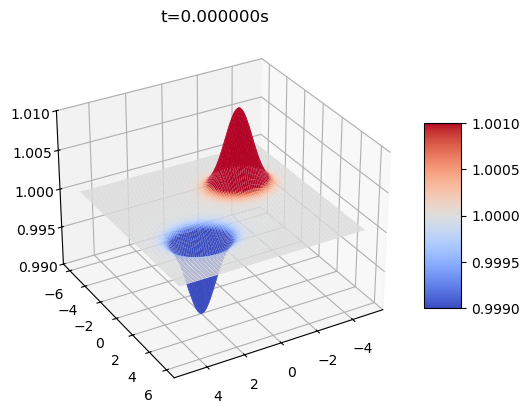

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
from matplotlib.animation import FuncAnimation, PillowWriter

matplotlib.rcParams["animation.embed_limit"] = 2**128


fig, ax = plt.subplots(
	subplot_kw={"projection": "3d"}, 
	figsize=(6, 4),
	layout="constrained",
)

example_file_idx = 0
z_lims = (0.99, 1.01)
c_lims = (0.999, 1.001)
plot3d_kwargs = {
    "rstride": 1, 
    "cstride": 1, 
    "cmap": "coolwarm",
    "linewidth": 0.01,
    "vmin": c_lims[0],
    "vmax": c_lims[1],
}

ax.view_init(30, 60)

# Genrate grids
x = np.linspace(ENV["x_start"], ENV["x_end"], ENV["nx"])
y = np.linspace(ENV["y_start"], ENV["y_end"], ENV["ny"])
t = np.linspace(ENV["t_start"], ENV["t_end"], ENV["ny"])
x, y = np.meshgrid(x, y)

z = np.fromfile(
    os.path.join(ENV["renderTmp"], render_files[example_file_idx]), np.float32
).reshape((ENV["nx"], ENV["ny"]))

surf = ax.plot_surface(x, y, z, **plot3d_kwargs)
ax.set_title(render_files[example_file_idx] + "s")
ax.set_zlim(*z_lims)
ax.zaxis.set_major_locator(LinearLocator(5))
fig.colorbar(surf, shrink=0.5, aspect=5, location="right")

def animate(frame, step=1):
    frame_idx = frame * step
    ax.clear()
    ax.set_zlim(*z_lims)
    ax.zaxis.set_major_locator(LinearLocator(5))
    print("Render frame:", f"{frame_idx + 1}/{len(render_files)}", end="\r")
    # Set title
    ax.set_title(render_files[frame_idx] + "s")
    # Plot the surface.
    render = os.path.join(ENV["renderTmp"], render_files[frame_idx])
    z = np.fromfile(render, np.float32).reshape((ENV["nx"], ENV["ny"]))
    surf = ax.plot_surface(x, y, z, **plot3d_kwargs)
    return surf

ani = FuncAnimation(
	fig, animate, 
	frames=FRAMES,
	fargs=(STEP,)
)
plt.show()

In [ ]:
writervideo = PillowWriter(fps=FPS)
ani.save("render/swe.gif", writer=writervideo)

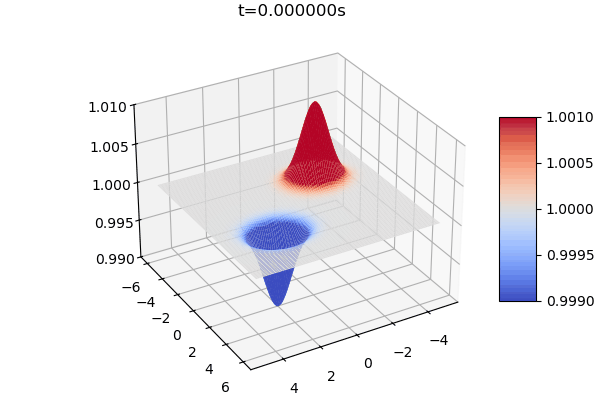

In [ ]:
from IPython.display import Image
Image("render/swe.gif")